<a href="https://colab.research.google.com/github/GWC-VT/IntroMLWorkshop/blob/main/GWCintroAIMLextended.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import statements- these allow us to use the packages that handle ML operations for us
import pandas as pd #allows us to create data frames for data processing
import numpy as np #allows sophisticated vector and data frame operations
#import os
import matplotlib.pyplot as plt #allows us to plot our results if desired
import seaborn as sns #also used for plotting data

## ML PACKAGES
from sklearn.model_selection import train_test_split #splits our data for us.
from sklearn.tree import DecisionTreeRegressor #the decision tree package
from sklearn.metrics import root_mean_squared_error #one metric for how well our model works

# GWC @ VT: Intro to Supervised Learning
In this notebook, we're going to illustrate the basic principles of the machine learning life cycle, starting with data and ending with a predictive model!

In this tutorial, we'll be using a decision tree model. This model splits the data into "leaves" based on factors like information gain and entropy. Sound interesting? Check out [this youtube video](https://www.youtube.com/watch?v=ZVR2Way4nwQ&pp=ygUdNCBibHVlIDEgYnJvd24gZGVjaXNpb24gdHJlZXM%3D).

For this tutorial, just know that decision trees are a very basic model that can be used for classification and regression problems.

## Step One: Business Understanding
Our goal here is to understand what the problem we're trying to solve is. In this case, our problem is "can we predict housing prices based on other factors like number of rooms and house age?"

*Note: in practice, this will be a much longer step. It's important to know exactly how your model is intended to work!!*

## Step Two: Data Understanding
Now that we have a problem, it is important to understand how we're actually going to use our data to solve this problem.

### Build a Dataframe
You can think of a data frame as a table of all our data, which allows us to do all of our preprocessing.

In [2]:
#Let's start by importing our data
filename = "/content/sample_data/california_housing_train.csv" #name it whatever file you want
df = pd.read_csv(filename, header = 0) #this is how we create a data frame with pandas

In [3]:
#next, let's print a few row from the data frame to see what we're working with.
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0


There's a few good takeaways here:


1.   Our data is numerical, not categorical. This means we can feed it directly into the model.
2.   Our label, "median_house_value", is also numerical. Therefore, this is a regression problem.


In [4]:
#Let's also make sure that there's no null values:
np.sum(df.isnull(), axis = 0)

,0
longitude,0
latitude,0
housing_median_age,0
total_rooms,0
total_bedrooms,0
population,0
households,0
median_income,0
median_house_value,0


## Step Three: Data Preparation
Here's where we prepare a training and test data set. We need to do a few things:


1.   Prepare our data frame so that it only contains our label and desired features, and make sure they're in the correct format
2.   Separate our data into a training and testing data set.



In [5]:
#1. First, let's only select the relevant variables. In this case, we want median housing age, total rooms, total bedrooms, and median income.
df = df.drop(columns = ['longitude', 'latitude', 'population', 'households'])
df.head()

,housing_median_age,total_rooms,total_bedrooms,median_income,median_house_value
0,15.0,5612.0,1283.0,1.4936,66900.0
1,19.0,7650.0,1901.0,1.8200,80100.0
2,17.0,720.0,174.0,1.6509,85700.0
3,14.0,1501.0,337.0,3.1917,73400.0
4,20.0,1454.0,326.0,1.9250,65500.0


In [6]:
#2. Separate our data into y (the label) and X (the features)
y = df['median_house_value']
X = df.drop(columns = ['median_house_value'], axis = 1)

In [7]:
#3. Use sklearn to randomly separate our data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

Things to note with the train_test_split method:
*   Returns four sets: `X train, X test, y train, y test`. Note that this order is important!! Make sure to use this consistently
*   `test_size` determines how big we want our test set. Here's we're using 0.3, or 30%, which is pretty typical.
*   `random_state` is just used to set the random state. long story short, we're using that here to make sure we all get the same random split of data. This isn't something you need to worry about for your own data sets.





In [8]:
#Let's look at the size of our training and testing blocks.
print("X train size: " + str(X_train.shape))
print("X test size: " + str(X_test.shape))
print("y train size: " + str(y_train.shape))
print("y test size: " + str(y_test.shape))

X train size: (11900, 4)
X test size: (5100, 4)
y train size: (11900,)
y test size: (5100,)


Here we can double check that we used the train_test_split correctly:
*   The first number shows the number of examples in each set. This should be consistent within the train set, and consistent within the test set. For us, this means X train and y train both have 11900 examples, while X test and y test both have 5100.
*   The second number is the number of variables included. This should be consistent between X and between y. Here, X has four variables (features), and y is blank, which means we're working with just the one label variable.
*   Finally, let's check that the test data size is 30% of the total size. In this case, 5100 is ~30% of the total, so we're good to go.





## Step Four: Modeling
Here's the exciting part: let's make our model!!

In this case, we're going to use a decision tree. This is a pretty basic model, with the following hyperparameters:

1.   `max_depth`: how "deep" we'll allow the tree to go
2.   `min_samples_leaf`: how large each leaf can be
3.   `criterion`: the criteria for how the tree will train

Let's start by making a function that will create, train, and evaluate a decision tree.

In [9]:
#Trains and evaluates a tree
def train_test_DT(X_train, X_test, y_train, y_test, depth, leaf=1, crit='squared_error'):
  model = DecisionTreeRegressor(max_depth= depth, min_samples_leaf = leaf, criterion = crit) #1
  model.fit(X_train, y_train) #2
  predictions = model.predict(X_test) #3
  mse_score = root_mean_squared_error(y_test, predictions) #4
  return mse_score

Some explanation of what's happening here:

Parameters: These are how we specify the details of our tree
*   `depth`: sets the max depth
*   `leaf`: sets the minimum leaves. we're starting by setting it to 1 as a default
*   `crit`: sets the criterion. we're making it mse by default

What the function does:
*   \#1: creates a `DecisionTreeRegressor` object with the hyperparameters we set using the function parameters
*   \#2: fits the model to our data. This is the training step
*   \#3: creates a set of predictions for our test data set
*   \#4: Calculates the root mean squared error. This is just one of many methods we can use to evaluate how well our model predicts new data points.






In [10]:
#Let's use this to make and test a series of trees with different depths!
max_depth_range = [1,3,7,30,50] # specify the depths we want to use
mse = [] #this will hold our outcomes

for md in max_depth_range:
  print(md)
  mse_score = train_test_DT(X_train, X_test, y_train, y_test, md)
  mse.append(mse_score)
  print(mse_score)

1
96384.83197830486
3
83265.85749224435
7
78046.04844226725
30
101937.38962799826
50
102063.1176857646


We've now made a model! However, our work's not done. We need to tune the hyperparameters to make a better model.

Let's start by looking at which of those depths we chose was the best:

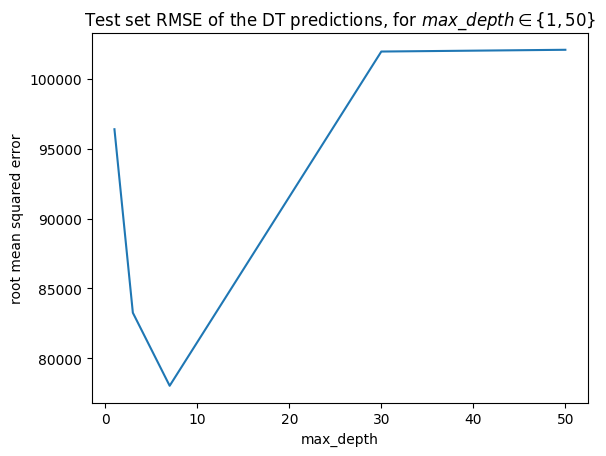

In [11]:
#Graph the results of mse_score
fig = plt.figure()
ax = fig.add_subplot(111)

sns.lineplot(x = max_depth_range, y = mse)

plt.title('Test set RMSE of the DT predictions, for $max\_depth\in\{1, 50\}$')
ax.set_xlabel('max_depth')
ax.set_ylabel('root mean squared error')
plt.show()

In reality, we'll want to do much more exhaustive hyperparameter tuning, such as a grid search, which allows us to iterate through different combinations of hyperparameters.

In this case, we're just going to look at leaf size and call it good for the sake of time :)


In [12]:
#Look at different leaf sizes
#Let's use this to make and test a series of trees with different depths!
min_leaf_range = [1,3,5,7, 21] # specify the leaf sizes we want to use
mse = [] #this will hold our outcomes

for ml in min_leaf_range:
  print(ml)
  mse_score = train_test_DT(X_train, X_test, y_train, y_test, depth = 7, leaf = ml)
  mse.append(mse_score)
  print(mse_score)

1
77922.63181529069
3
77743.92879567742
5
77563.48958502166
7
77343.45992449843
21
77408.42306941416


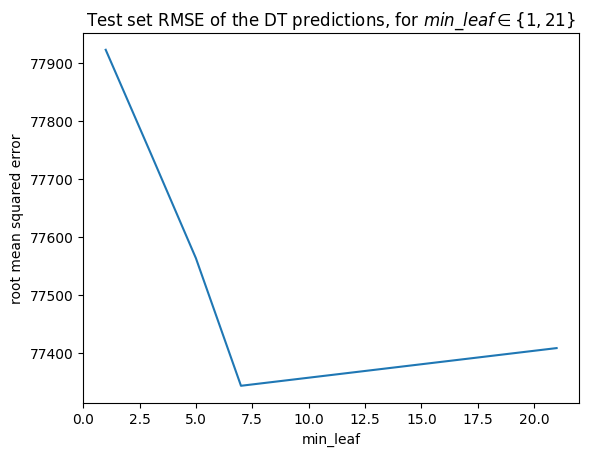

In [13]:
#Graph the results of mse_score for leaf size
fig = plt.figure()
ax = fig.add_subplot(111)

sns.lineplot(x = min_leaf_range, y = mse)

plt.title('Test set RMSE of the DT predictions, for $min\_leaf\in\{1, 21\}$')
ax.set_xlabel('min_leaf')
ax.set_ylabel('root mean squared error')
plt.show()

Ok, let's make our final model using our selected hyperparameters!

In [14]:
#Our final model!!
final_model = DecisionTreeRegressor(max_depth = 7, min_samples_leaf = 7)
final_model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=7, min_samples_leaf=7)

## Step Five: Evaluation
Let's look at how well our model performs!

In [15]:
#Use the "score" method to evaluate our performance.
print("Train set score: " + str(final_model.score(X_train, y_train)))
print("Test set score: " + str(final_model.score(X_test, y_test)))

Train set score: 0.6072678504428453
Test set score: 0.5580165099153362


Here, we really want to focus on test set score! This is an indicator of how our model will perform on real world, previously unseen data.

A score of 0.56 is... fine. It'll depend on your project specification if this is good enough. Real world applications will also use plenty of other validation techniques to determine efficacy.

However, this exemplifies one of the reasons more advanced techniques were made. For example, Random Forest is an ensemble model which actually combines multiple decision trees. Going further, neural nets use an entirely different design, which includes hidden layers that allow additional processing.

Note that even with these more advanced techniques, this life cycle process is the same! The hyperparameters you're tuning will be different, but you can follow these same steps :)

## Step Six: Deployment
Time to make your model known! Some options:

*   GitHub: make your own repo to share your code with the public, or even invite others to collaborate
*   Online: create a website that uses your model!
*   User Interface: make a usable interface so that people don't need to interact with the code to use the model!



---

# Some Extension Ideas

## Ensemble Methods
Ensemble methods combine multiple simple models in order to minimize tradeoff between variance and bias.

One example of an ensemble method is the **Random Forest model**, which creates multiple decision trees, each one a separate subset of our training data. We then combine these trees. This is done in a process called "bagging", or bootstrap aggregation.

In [16]:
from sklearn.ensemble import RandomForestRegressor

In [19]:
#create the model
forest_model = RandomForestRegressor(n_estimators=100) #n_estimators = the hyperparameter for # of trees


forest_model.fit(X_train, y_train) #as always, fit model to data

forest_preds = forest_model.predict(X_test) #make predictions on test data
print(forest_preds)


forest_mse_score = root_mean_squared_error(y_test, forest_preds) #calculate RMSE
print(forest_mse_score)

[118762.   327207.12 137431.01 ... 248689.01 218826.02 162816.  ]
72991.5281101681


## Tuning Our Hyperparameters using a grid search

A grid search allows us to go through a combination of hyperparameter combinations to determine which gives us best model performance.

Additionally, we'll be using cross validation, which is a way of allowing us to use our entire data set (training and test) for training.

In [20]:
#import sklearn's grid search tool
from sklearn.model_selection import GridSearchCV

In [21]:
#Specify some depth options
depths = [4,8,16, 32]

#Specify some leaf options
leafs = [25, 50, 100, 200]

# Create a "parameter grid" from these values
param_grid={'max_depth':depths, 'min_samples_leaf':leafs}
param_grid

#Use CV grid search on a new model
optimal_model = DecisionTreeRegressor()
grid = GridSearchCV(optimal_model, param_grid, cv=5)
grid_search = grid.fit(X_train, y_train)

#Examine results
print('Optimal hyperparameters: {0}'.format(grid_search.best_params_)) #grid_search

# print best accuracy score resulting from this configuration
print('Score: {0}'.format(grid_search.best_score_))

Optimal hyperparameters: {'max_depth': 16, 'min_samples_leaf': 25}
Score: 0.567908610955709
